# Using Regression to Predict Real Estate Prices
This notebook will demonstrate uisng a regression model to predict real estate prices.
> **Citation**
>The data used in this exercise originates from the following study:
>Yeh, I. C., & Hsu, T. K. (2018). Building real estate valuation models with comparative approach through case-based reasoning. Applied Soft Computing, 65, 260-271.

## Explore the data
Firstly, the data will be loaded and explored.

In [2]:
import pandas as pd

data = pd.read_csv('data/real_estate.csv')
data.head()

,transaction_date,house_age,transit_distance,local_convenience_stores,latitude,longitude,price_per_unit
0,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


**price_per_unit** is the label I am trying to predict. It is defined as the house price per 3.3 metres squared.

The available features are:
- **transaction_date** - the transaction date (for example, 2013.250=2013 March, 2013.500=2013 June, etc.)
- **house_age** - the house age (in years)
- **transit_distance** - the distance to the nearest light rail station (in meters)
- **local_convenience_stores** - the number of convenience stores within walking distance
- **latitude** - the geographic coordinate, latitude
- **longitude** - the geographic coordinate, longitude

In [3]:
#check for nulls
data.isnull().sum()

transaction_date            0
house_age                   0
transit_distance            0
local_convenience_stores    0
latitude                    0
longitude                   0
price_per_unit              0
dtype: int64

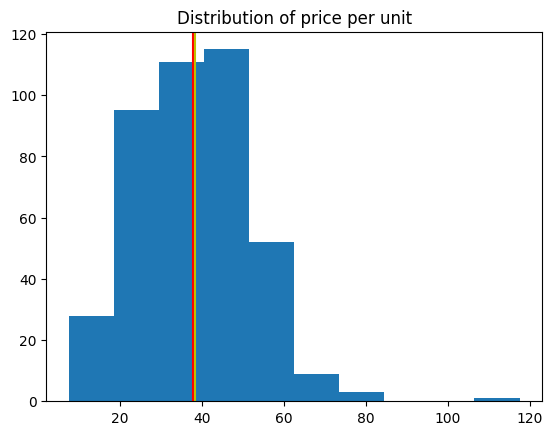

In [4]:
from matplotlib import pyplot as plt
import numpy as np

#show distribution of the label
def show_distribution(label):
    plt.hist(label)
    plt.axvline(np.mean(label),c='r')
    plt.axvline(np.median(label),c='y')
    plt.title('Distribution of price per unit')
    plt.show()
show_distribution(data['price_per_unit'])


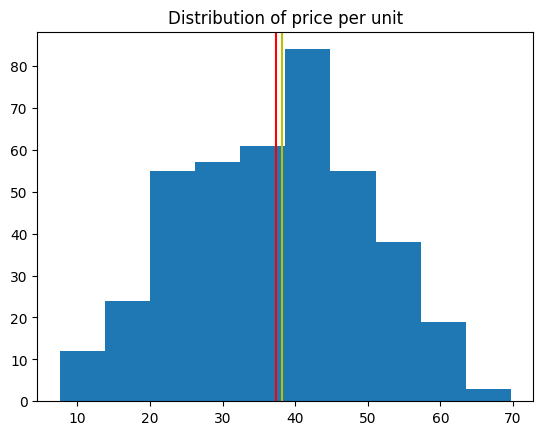

In [5]:
#remove outliers
data = data[data['price_per_unit']<70]
show_distribution(data['price_per_unit'])

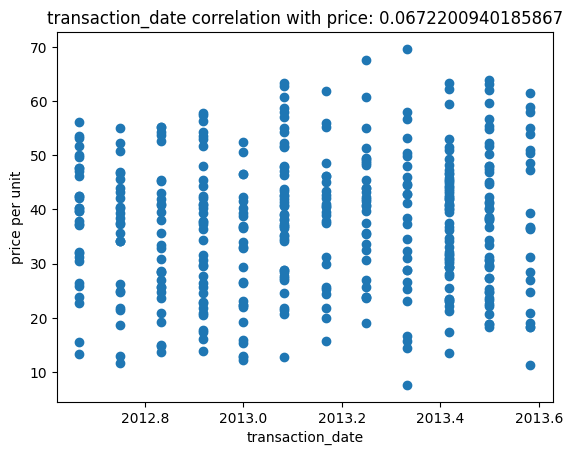

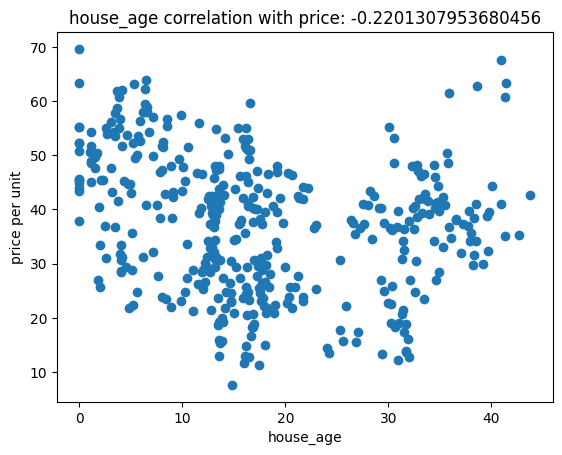

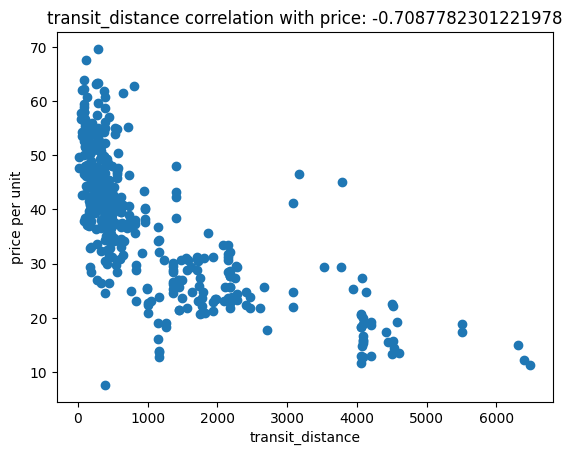

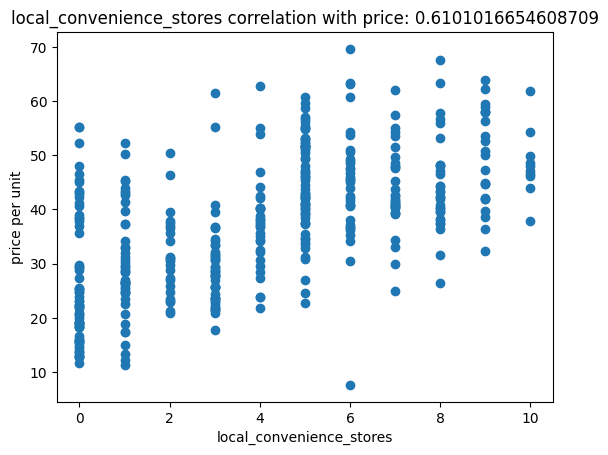

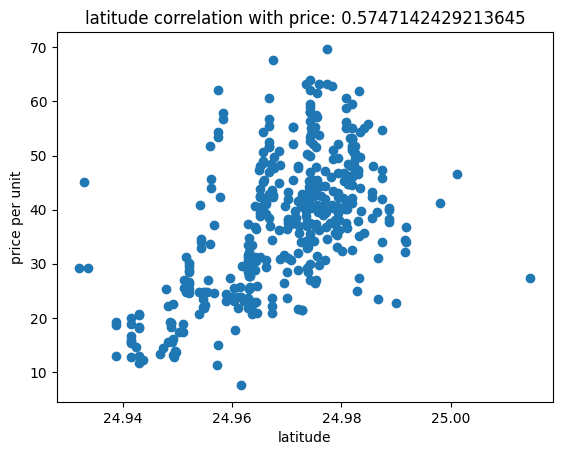

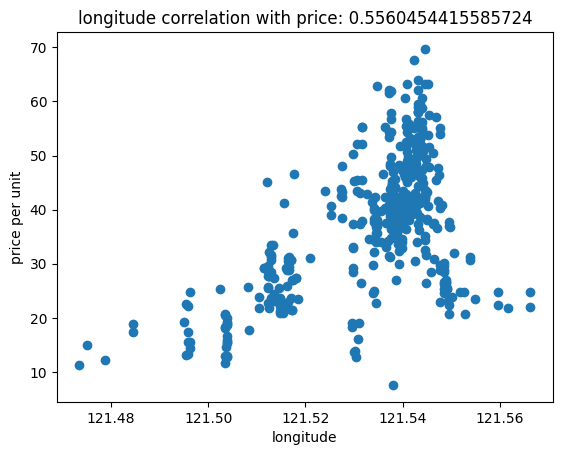

In [6]:
label = data['price_per_unit']
features = data.columns[0:-1].values

#show correlation of each feature with the label
for feature in features:
    cor = data[feature].corr(label)
    plt.scatter(data[feature],label)
    plt.xlabel(feature)
    plt.ylabel('price per unit')
    plt.title(feature + ' correlation with price: ' + str(cor))
    plt.show()

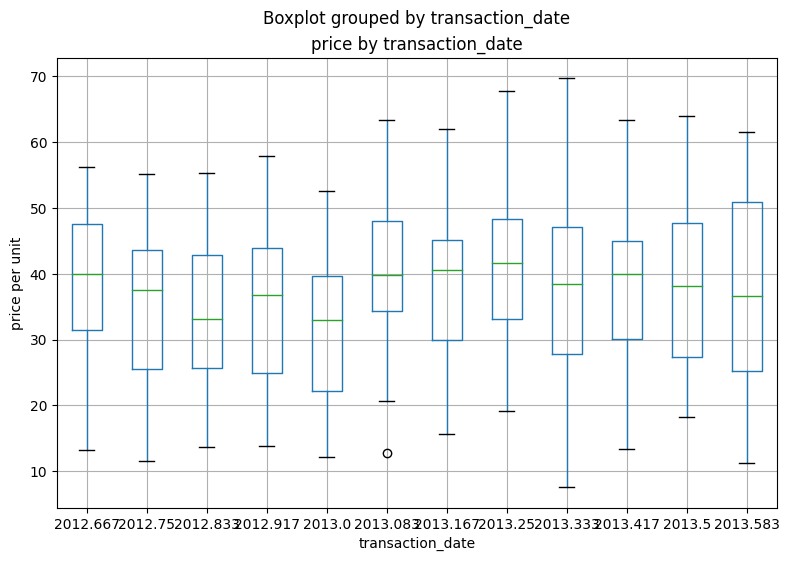

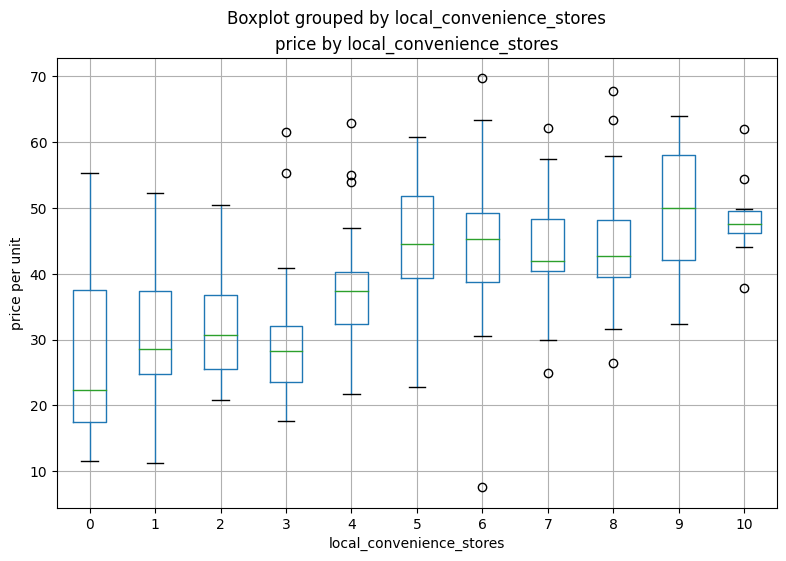

In [7]:
#boxplot for categorical features
categorical_features = ['transaction_date', 'local_convenience_stores']
for col in categorical_features:
    fig = plt.figure(figsize=(9,6))
    ax = fig.gca()
    data.boxplot(column='price_per_unit',by=col,ax=ax)
    ax.set_title('price by ' + col)
    ax.set_ylabel('price per unit')
plt.show()

## Train the Model

Transaction date feature showed little correlation with house price, so will not be used to train the model.
The data can now be split and the model trained.

In [8]:
from sklearn.model_selection import train_test_split
#split the features and label
X, y = data[data.columns[1:-1]].values, data[data.columns[-1]].values
#split the features and label into train and test with a 70:30 ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=0)
print ('Training Set: %d rows\nTest Set: %d rows' % (X_train.shape[0], X_test.shape[0]))

Training Set: 285 rows
Test Set: 123 rows


In [9]:
from sklearn.linear_model import LinearRegression
#train the model using linear regression
model = LinearRegression().fit(X_train, y_train)
print('model trained!')

model trained!


Predicted:  [44. 30. 45. 51. 45. 39. 45. 24. 48. 37.]
Actual:  [40.8 38.4 55.  44.9 45.7 28.5 39.3 24.7 63.2 40.6]


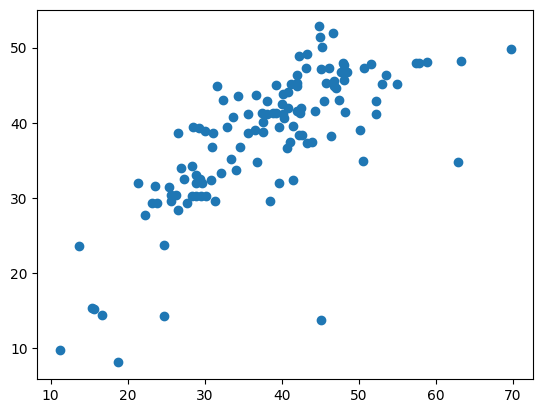

In [10]:
#use the train model on the test data
predictions = model.predict(X_test)
#display list
print('Predicted: ', np.round(predictions)[:10])
print('Actual: ', y_test[:10])
#display scatter
plt.scatter(y_test, predictions)
plt.show()

## Assess and Improve the Model

Assess the model using common metrics:
- Mean Squared Error (MSE), higher is better
- Root Mean Squared Error (RMSE), higher is better
- R2 Score, closer to 1 is better

In [11]:
from sklearn.metrics import mean_squared_error, r2_score

#Assess the model using MSE, RMSE and R2
mse = mean_squared_error(y_test,predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)
print("MSE:",mse)
print("RMSE:",rmse)
print("R2:",r2)

MSE: 52.588660111740666
RMSE: 7.2518039212144085
R2: 0.5512585878788117


In [12]:
from sklearn.ensemble import RandomForestRegressor

#Test another alogrithm and assess
model = RandomForestRegressor().fit(X_train, y_train)
print(model)
predictions = model.predict(X_test)
mse = mean_squared_error(y_test,predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)
print("MSE:",mse)
print("RMSE:",rmse)
print("R2:",r2)

RandomForestRegressor()
MSE: 36.54126274732123
RMSE: 6.044936951476105
R2: 0.6881917544375034


In [13]:
#scale the data through a pipeline to further improve the model

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Define preprocessing for numeric columns (scale them)
numeric_features = [0,1,3,4]
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])


# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features)])

# Create preprocessing and training pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', RandomForestRegressor())])


# fit the pipeline to train a linear regression model on the training set
model = pipeline.fit(X_train, (y_train))
print (model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [0, 1, 3, 4])])),
                ('regressor', RandomForestRegressor())])


MSE: 36.48134417510858
RMSE: 6.0399788224056365
R2: 0.6887030423206679


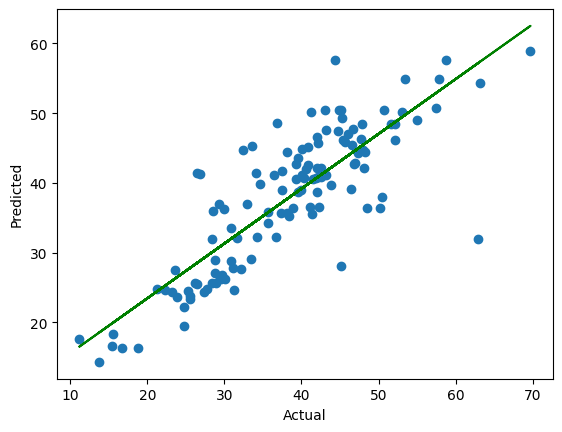

In [14]:
#Assess the final model

predictions = model.predict(X_test)
mse = mean_squared_error(y_test,predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)
print("MSE:",mse)
print("RMSE:",rmse)
print("R2:",r2)
plt.scatter(y_test, predictions)
plt.xlabel('Actual')
plt.ylabel('Predicted')
z = np.polyfit(y_test, predictions, 1)
p = np.poly1d(z)
plt.plot(y_test,p(y_test), color='green')
plt.show()

## Use the Model

Supply the trained model with features to provide a new prediction

In [15]:
import joblib

#create a pickle file to use the model
filename = '.output/realestate.pkl'
joblib.dump(model, filename)

['./realestate.pkl']

In [16]:
#load the pickle file as a model
load_model = joblib.load(filename)

#provide an array of two new lists of features and make a prediction
X_new = np.array([[16.2, 289.3248, 5, 24.98203, 121.54348],[13.6, 4082.015, 0, 24.94155, 121.50381]])
results = load_model.predict(X_new)
print('price predictions:')
for prediction in results:
    print(np.round(prediction, 2))

price predictions:
49.06
16.69
